In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

import shap
shap.initjs()

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Example/abalone.csv')

In [ ]:
data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [ ]:
data.columns = [col.lower() for col in data.columns]

In [ ]:
y = data['rings']
x = data.drop('rings', axis=1)

In [ ]:
x['sex.M'] = [1 if s == 'M' else 0 for s in x['sex']]
x['sex.F'] = [1 if s == 'F' else 0 for s in x['sex']]
x['sex.I'] = [1 if s == 'I' else 0 for s in x['sex']]

In [ ]:
x = x.drop('sex', axis=1)

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(x, y)

XGBRegressor(objective='reg:squarederror')

# GPU setting
* gpu_predictor를 지정해줘야 함

In [ ]:
# explainer가 작동하는지는 테스트 필요
model.set_param({"predictor": "gpu_predictor"})
explainder = shap.Explainder(model)
shap_values = model.predict(x, pred_contribs=True)

In [ ]:
model = xgboost.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
model.fit(X_train, y_train)

shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap_values = shap.Explainer(model, X_train)(X_test)

# or -----------------------------

n_trees = 200
dmat  = xgboost.DMatrix(X_train, y_train)
model = xgboost.train({"tree_method": "gpu_hist"}, dmat, n_trees)
model.set_param({"predictor": "gpu_predictor"})

shap_values = model.predict(dmat, pred_contribs=True)

# __SHAP__

* .values
* .base_values
* .data

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(x)

In [ ]:
data.shape

(4177, 9)

In [ ]:
shap_values.values.shape

(4177, 10)

In [ ]:
len(shap_values.base_values)

4177

# __Bar Plot__

특정 data sample에 대해 각 feature의 shap value를 보여줌


# __Waterfall__
1. 여기서는 training data를 x로 바로 사용했지만 test data를 x로 사용하여 값을 확인
2. Waterfall plot은 sample x의 예측값에 얼마만큼의 feature별 shape value가 base value에 추가되었는가를 보여줌

---

첫 번째 abalone의 ring(target)을 증가, 감소시키는 데 각 변수가 얼마나 영향을 주었는지 확인하는 plot

* $E[f(x)]$는 모든 abalone에 대한 평균 예측 ring 수
* $f(x)$는 이 abalone의 예측 ring 수
* 따라서 그림의 해당 관측치(abalone)의 예측값(predicted ring)이 평균 예측값(mean of predicted rings)에서 변수의 영향을 어떻게 받아 달라졌는지 보여줌
* feature의 shap 값이 클 수록 해당 변수가 예측에 중요한 영향을 주었음을 의미

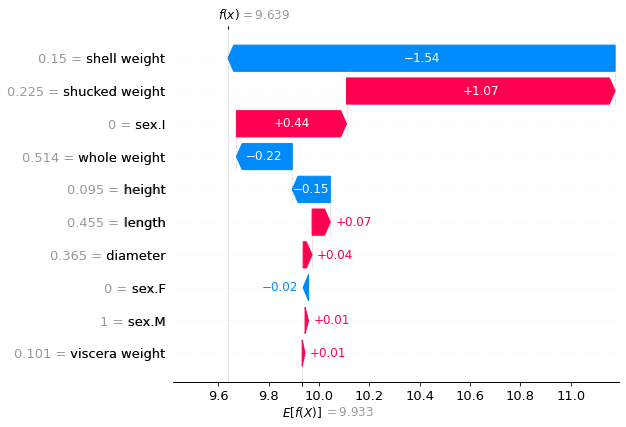

In [ ]:
shap.plots.waterfall(shap_values[0])

# __Force Plot__

* waterfall과 같은 정보를 주는 다른 시각화 plot
* plot의 굵은 숫자가 해당 관측치의 값을 나타내고 주어진 변수 별 증가, 감소 값을 통해 평균 예측에 어떻게 도달하는지 나타냄

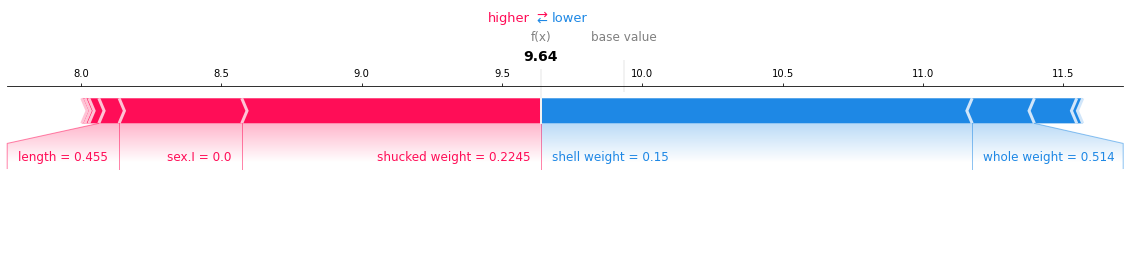

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0], matplotlib=True, out_names='Lengh(cm)')

# __Decision plot__

* waterfall, force plot은 개별 관측치를 해석하는 데 좋은 plot
* 일반적인 해석을 위해서는 shap value를 종합해야 함
* 아래 decision plot은 0에서 9번의 abalone의 결과로 각 선이 하나의 abalone을 나타내며 평균 예측값인 9.64(아래)에서 각각 어떻게 변화했는지를 보여줌
* decision path를 보여줌

In [ ]:
shap.decision_plot(
    explainer.expected_value,
    explainer.shap_values(x)[0],
    feature_names=list(x.columns),
    )

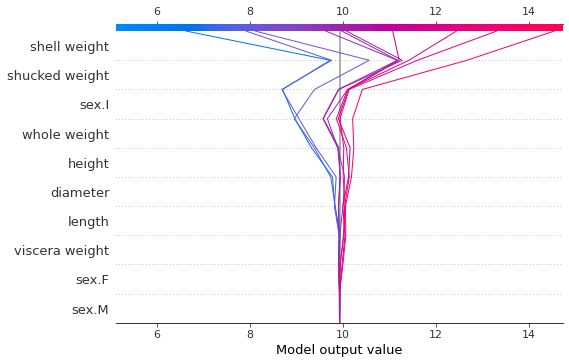

In [ ]:
shap.decision_plot(
    explainer.expected_value,
    explainer.shap_values(x)[0:10],
    feature_names=list(x.columns),
    highlight = [1, 2],
    )

# __Mean SAHP__

* 각 변수 shap value의 절댓값으로 큰 값일수록 크거나 작은 shap 값이다.
*다시 말해, 변수가 모델의 예측에 중요한 영향을 준다. (In other words, these are the features that have a significant impact on the model’s predictions.)
* feature importance와 비슷하다고 볼 수 있다.
* 그러나 본연적으로 target과 feature 사이의 관계를 설명하진 못한다.

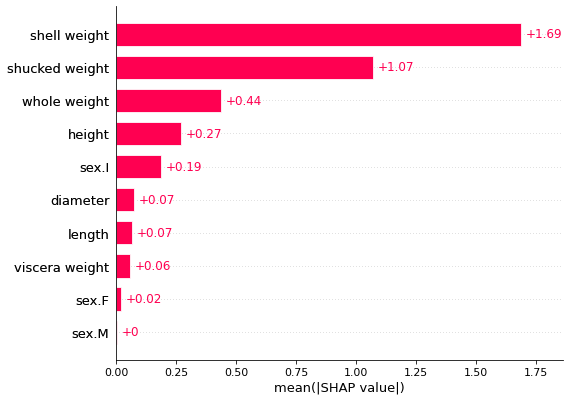

In [ ]:
shap.plots.bar(shap_values)

# __Beeswarm__

* shell weight은 변수 값이 증가함에 따라 shap value가 어떻게 증가하는지 보여줌
* 다시 말해, shell weight이 클수록 shape value, 즉 중요도가 양수로 커지고, ring이 많다고 예측한다.
* 반면 shucked weight는 반대 관계를 보여주며 큰 low의 feature 값이 작은 shap value와 연관되어 있다.

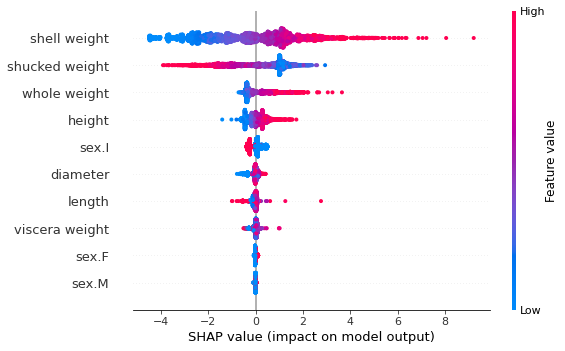

In [ ]:
shap.plots.beeswarm(shap_values)

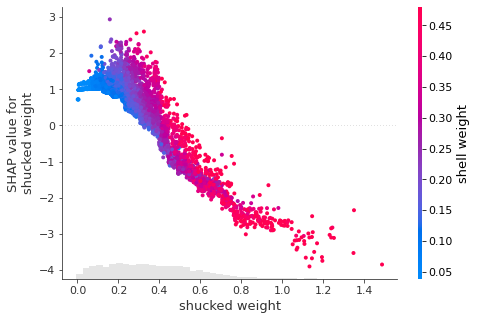

In [ ]:
# 설명하기 좋은 변수를 자동으로 추출(오른쪽 바)
shap.plots.scatter(shap_values[:,'shucked weight'], color=shap_values)

In [ ]:
data.columns

Index(['sex', 'length', 'diameter', 'height', 'whole weight', 'shucked weight',
       'viscera weight', 'shell weight', 'rings'],
      dtype='object')

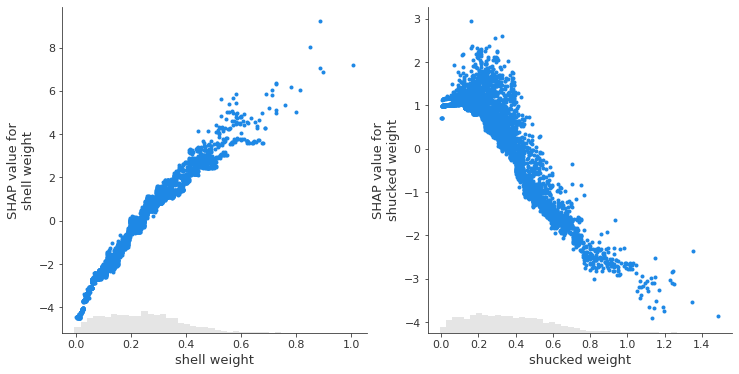

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

shap.plots.scatter(shap_values[:,'shell weight'], ax=ax[0], show=False)
shap.plots.scatter(shap_values[:, 'shucked weight'], ax=ax[1])

# __binary__
binary에서는 shap value가 log odds에 더해진다
1. shucked weightsms log-odds를 1.26 증가시킨다.
2. 즉, 1로 예측할 가능성을 증가시킨다.
---
__continuous__
* $f(x) = E[f(x)] $ + SHAP

__binary__
* $ln(\frac{p}{1-p}) = E[ln(\frac{p}{1-p})]$ + SHAP

In [ ]:
y = [1 if y_>10 else 0 for y_ in y]

model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(x, y)

XGBClassifier()

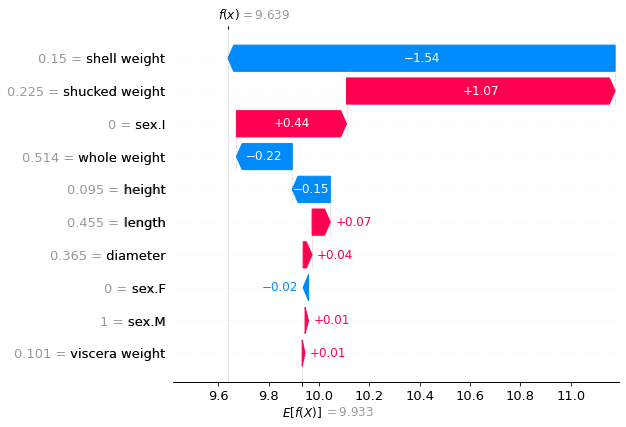

In [ ]:
shap.plots.waterfall(shap_values[0])

# __SHAP interaction__

* \# 4177 10x10 matrices
* matrix는 mean prediction과 비교했을 때 각 변수가 모델의 예측에 얼마나 기여했는지를 나타낸다. (matrix + mean prediction = prediction)
* sex.M과 height의 interaction은 rings(target)을 0.26(0.13*2)만큼 증가시킨다.

In [ ]:
shap_interaction = explainer.shap_interaction_values(x)
print(np.shape(shap_interaction))

(4177, 10, 10)


In [ ]:
pd.DataFrame(shap_interaction[0], index=x.columns, columns=x.columns)

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
length,-0.021756,-0.013302,0.067146,-0.011080,-0.003797,-0.012730,0.066064,0.000000,0.000431,0.001417
diameter,-0.013302,-0.054427,-0.004394,0.054882,0.047210,0.005670,-0.000911,0.000308,0.000000,0.000402
height,0.067146,-0.004394,-0.284189,0.073108,-0.063884,0.042913,-0.030794,0.009632,-0.000231,0.039609
whole weight,-0.011080,0.054882,0.073108,-0.373225,-0.009765,-0.016640,0.067351,0.000301,0.000000,-0.006601
shucked weight,-0.003797,0.047210,-0.063884,-0.009764,1.398716,0.000005,-0.333564,-0.000345,-0.014428,0.046161
viscera weight,-0.012730,0.005670,0.042913,-0.016640,0.000005,0.023523,-0.031276,0.000044,0.000000,0.000000
shell weight,0.066064,-0.000911,-0.030794,0.067351,-0.333565,-0.031276,-1.419237,0.000082,0.008390,0.136872
sex.M,0.000000,0.000308,0.009632,0.000301,-0.000345,0.000044,0.000082,0.003665,0.000000,0.000000
sex.F,0.000431,0.000000,-0.000231,0.000000,-0.014428,0.000000,0.008390,0.000000,-0.015407,0.000000
sex.I,0.001417,0.000402,0.039609,-0.006601,0.046162,0.000000,0.136872,0.000000,0.000000,0.219164


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


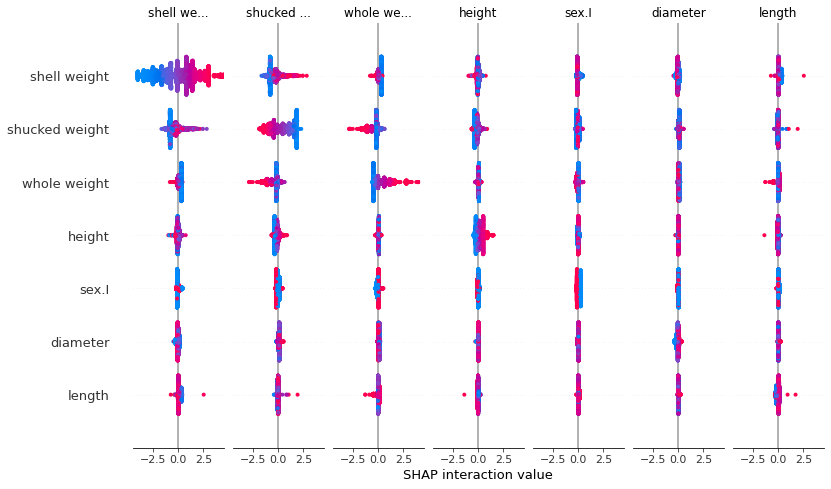

In [ ]:
shap.summary_plot(shap_interaction, x)

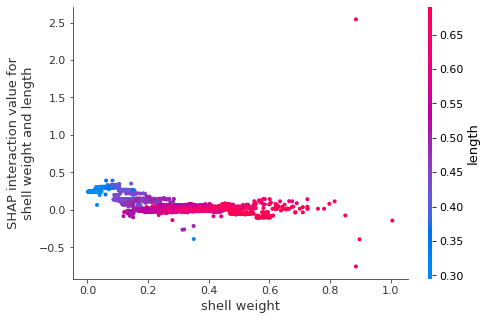

In [ ]:
shap.dependence_plot(
    ('shell weight', 'length'),
    shap_interaction, x,
    display_features=x
)